In [1]:
from IPython.core.debugger import set_trace
from IPython.display import clear_output
import importlib

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../financial_options')

import datetime as dt
import black_scholes as bs
import volatilityProbability as vp

In [2]:
data_dir = 'chain_data'

In [3]:
chains = dict()
for file in os.listdir('chain_data'):
    data_table = pd.read_csv('chain_data/'+file)
    data_table.drop([1,2,3,4], axis=0, inplace=True)
    data_table.drop(['TickerID', 'Last','BidSize', 'AskSize','LastSize'], axis=1,inplace=True)
    data_table.drop(['Volume','OpenInt','ClosePrice','SecType'],axis=1,inplace=True)
    data_table.drop(['LocalSymbol'], axis=1,inplace=True)
    data_table.reset_index(inplace=True, drop=True)
    
    expiration = dt.datetime.strptime(str(int(data_table.Expiration[5])),'%Y%m%d') + dt.timedelta(hours=22, minutes=15)
    current_time = dt.datetime.strptime(data_table.RefreshDate[5],'%d/%m/%Y %H:%M:%S')
    tte = (expiration - current_time).total_seconds()/60/60/24
    tte = np.round(tte,2)
    chains.update({tte: data_table})

In [4]:
# Clear -1 prices
for tte, table in chains.items():
    while np.any(table.Bid == -1):
        table.drop(np.where((table.Bid == -1))[0][0], axis=0, inplace=True)
        table.reset_index(inplace=True, drop=True)
        
for tte, table in chains.items():
    table['Mid'] = (table.Bid + table.Ask) / 2

In [5]:
chains.keys()

dict_keys([2.15, 3.15, 4.15, 7.15, 9.15, 11.15, 15.15, 16.15, 18.15, 21.15, 23.15, 25.15, 28.15, 30.15, 31.15, 32.15, 35.15, 37.15, 39.15, 46.15, 53.15, 60.15, 66.15, 67.15, 77.14, 94.14, 95.14, 108.14, 122.14, 123.14, 137.14, 169.14, 213.14, 214.14, 228.14, 248.14, 304.14, 318.14, 395.14, 396.14, 584.14, 585.14, 948.14])

In [6]:
vol_curves = dict()
for tte, table in chains.items():
    ones = np.ones(table.Bid.as_matrix()[1:].shape)
    s = table.iloc[[0]].Mid[0]*ones
    k = table.Strike.as_matrix()[1:]
    right = table.Right.as_matrix()[1:]=='P'
    mid = table.Mid.as_matrix()[1:]
    vol = bs.option_vol(s, k, right, mid, tte*ones)
    vol_curves.update({tte: [s[0], k, vol]})

In [7]:
vol_curves.keys()

dict_keys([2.15, 3.15, 4.15, 7.15, 9.15, 11.15, 15.15, 16.15, 18.15, 21.15, 23.15, 25.15, 28.15, 30.15, 31.15, 32.15, 35.15, 37.15, 39.15, 46.15, 53.15, 60.15, 66.15, 67.15, 77.14, 94.14, 95.14, 108.14, 122.14, 123.14, 137.14, 169.14, 213.14, 214.14, 228.14, 248.14, 304.14, 318.14, 395.14, 396.14, 584.14, 585.14, 948.14])

<IPython.core.display.Javascript object>


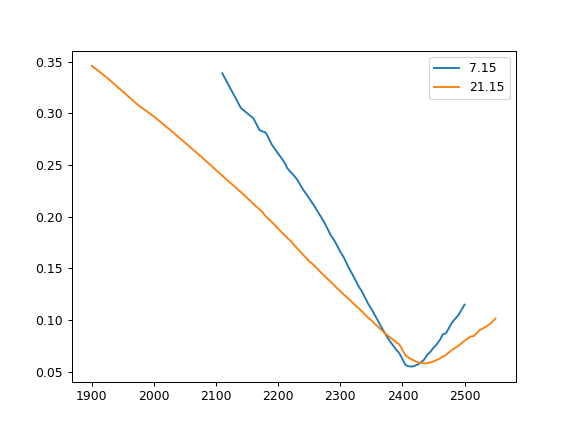

In [8]:
tte1 = 7.15
tte2 = 21.15

plt.figure()
plt.plot(vol_curves[tte1][1], vol_curves[tte1][2], label=str(tte1))
plt.plot(vol_curves[tte2][1], vol_curves[tte2][2], label=str(tte2))
plt.legend()

In [22]:
# Retrieve Data
k1 = vol_curves[tte1][1]
k2 = vol_curves[tte2][1]
vol1 = vol_curves[tte1][2]
vol2 = vol_curves[tte2][2]

# Adjust k2
s = vol_curves[tte1][0]
s_delta = vol_curves[tte2][0]-s
k2 = k2 + s_delta

# Crop Curves
lims = (2200,2550)
k1_out = np.logical_and(k1 < lims[0], k1 < lims[1])
vol1 = vol1[~k1_out]
k1 = k1[~k1_out]
k2_out = np.logical_and(k2 < lims[0], k2 < lims[1])
vol2 = vol2[~k2_out]
k2 = k2[~k2_out]

# Extending TTE1
k2_out = k2 < k1[0]
k1_new = k2[k2_out]
m = np.mean(np.diff(vol1[0:5])/np.diff(k1[0:5]))
b = vol1[0] - m*k1[0]
vol1_new = m * k1_new + b
k1 = np.concatenate([k1_new, k1])
vol1 = np.concatenate([vol1_new, vol1])
k2_out = k2 > k1[-1]
k1_new = k2[k2_out]
m = np.mean(np.diff(vol1[-5:])/np.diff(k1[-5:]))
b = vol1[-1] - m*k1[-1]
vol1_new = m * k1_new + b
k1 = np.concatenate([k1, k1_new])
vol1 = np.concatenate([vol1, vol1_new])

#plt.figure()
#plt.plot(k1,vol1)
#plt.plot(k2,vol2)

# Resample k1, vol1 and k2, vol2
n = 256+2
k = np.linspace(k2[0], k2[-1], n)
fourier_shifter = (np.sum(k<s)-2)/len(k)
vol1 = np.interp(k, k1, vol1)
vol2 = np.interp(k, k2, vol2)

# Calculate PDF
vol_filter = False
filter_order = 1
pdf_t1, k_pdf_t1, vol1, k1 = vp.volcurve2pdf(s,k,vol1,tte1, vol_filter=True, filter_order=filter_order)
pdf_t2, k_pdf_t2, vol2, k2 = vp.volcurve2pdf(s,k,vol2,tte2, vol_filter=True, filter_order=filter_order)

<IPython.core.display.Javascript object>


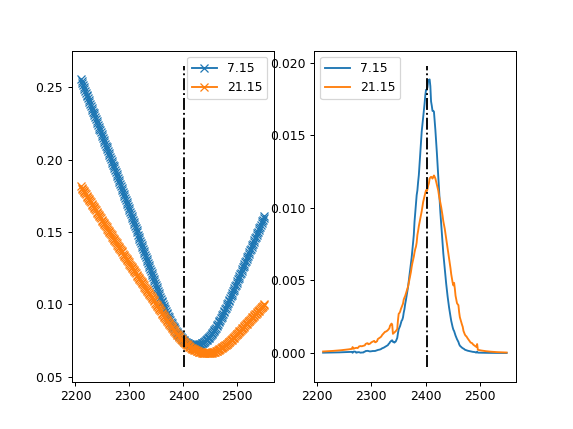

In [23]:
plt.figure()
plt.subplot(121)
plt.plot(k1, vol1, label=str(tte1), marker='x')
plt.plot(k2, vol2, label=str(tte2), marker='x')
plt.plot([s,s], plt.ylim(),'k-.')
plt.legend()
plt.subplot(122)
plt.plot(k_pdf_t1, pdf_t1, label=str(tte1))
plt.plot(k_pdf_t2, pdf_t2, label=str(tte2))
plt.plot([s,s], plt.ylim(),'k-.')
plt.legend()

<IPython.core.display.Javascript object>


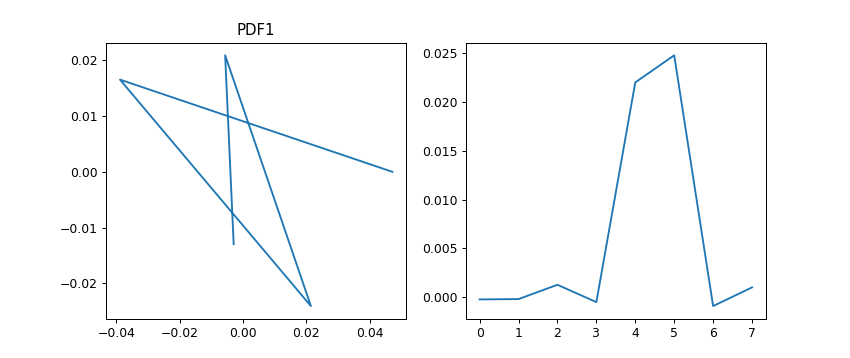

<IPython.core.display.Javascript object>


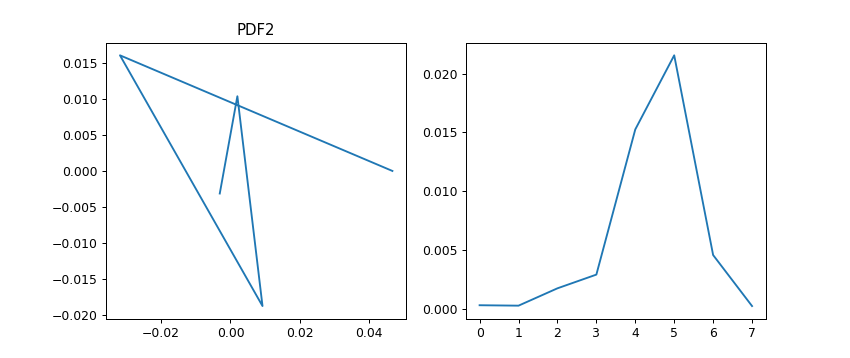

<IPython.core.display.Javascript object>


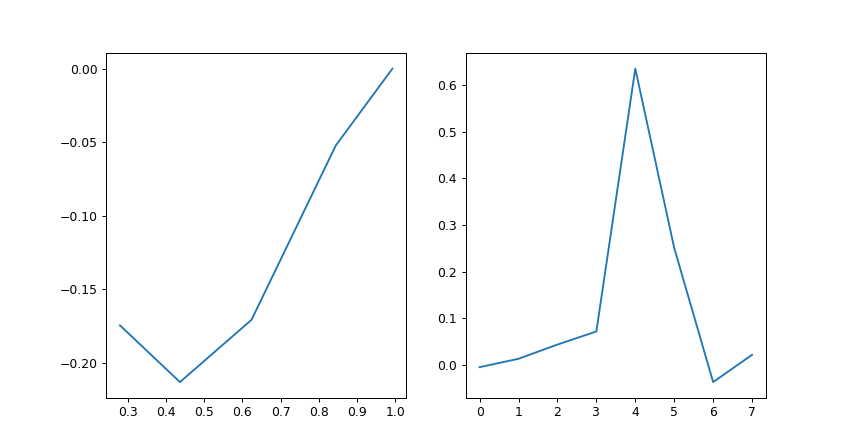

In [27]:
n_cutoff = 5
PDF_t1 = np.fft.rfft(pdf_t1,norm='ortho')
PDF_t1 = PDF_t1[0:n_cutoff]
PDF_t2 = np.fft.rfft(pdf_t2,norm='ortho')
PDF_t2 = PDF_t2[0:n_cutoff]

PDF_t1t2 = PDF_t2 / PDF_t1
pdf_t1t2 = np.fft.irfft(PDF_t1t2)
pdf_t1t2 = np.roll(pdf_t1t2, int(fourier_shifter*len(pdf_t1t2)))

plt.figure(figsize=(9.5,4))
plt.subplot(121)
plt.title('PDF1')
plt.plot(PDF_t1.real, PDF_t1.imag)
plt.subplot(122)
plt.plot(np.fft.irfft(PDF_t1))

plt.figure(figsize=(9.5,4))
plt.subplot(121)
plt.title('PDF2')
plt.plot(PDF_t2.real, PDF_t2.imag)
plt.subplot(122)
plt.plot(np.fft.irfft(PDF_t2))

plt.figure(figsize=(9.5,5))
plt.subplot(121)
plt.plot(PDF_t1t2.real, PDF_t1t2.imag)
plt.subplot(122)
plt.plot(pdf_t1t2)

## 0-t1-t2-t3

<IPython.core.display.Javascript object>


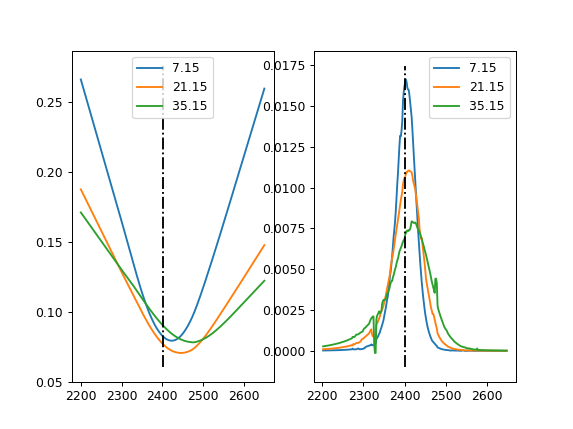

In [30]:
tte1 =  7.15
tte2 = 21.15
tte3 = 35.15
# Retrieve Data
k1 = vol_curves[tte1][1]
k2 = vol_curves[tte2][1]
k3 = vol_curves[tte3][1]
vol1 = vol_curves[tte1][2]
vol2 = vol_curves[tte2][2]
vol3 = vol_curves[tte3][2]

# Adjust k2
s = vol_curves[tte1][0]
s_delta12 = vol_curves[tte2][0]-s
k2 = k2 + s_delta12
s_delta13 = vol_curves[tte3][0]-s
k3 = k3 + s_delta13

# Crop Curves
def crop_curve(k1, vol1, lims):
    k1_out = np.logical_and(k1 < lims[0], k1 < lims[1])
    vol1 = vol1[~k1_out]
    k1 = k1[~k1_out]
    return k1, vol1

lims = (2200,2550)
k1, vol1 = crop_curve(k1, vol1, lims)
k2, vol2 = crop_curve(k2, vol2, lims)
k3, vol3 = crop_curve(k3, vol3, lims)

# Extending TTE1
def extend_curve(k1,vol1, k2, vol2):
    k2_out = k2 < k1[0]
    k1_new = k2[k2_out]
    m = np.mean(np.diff(vol1[0:5])/np.diff(k1[0:5]))
    b = vol1[0] - m*k1[0]
    vol1_new = m * k1_new + b
    k1 = np.concatenate([k1_new, k1])
    vol1 = np.concatenate([vol1_new, vol1])
    k2_out = k2 > k1[-1]
    k1_new = k2[k2_out]
    m = np.mean(np.diff(vol1[-5:])/np.diff(k1[-5:]))
    b = vol1[-1] - m*k1[-1]
    vol1_new = m * k1_new + b
    k1 = np.concatenate([k1, k1_new])
    vol1 = np.concatenate([vol1, vol1_new])
    return k1, vol1

k1, vol1 = extend_curve(k1,vol1, k3, vol3)
k2, vol2 = extend_curve(k2,vol2, k3, vol3)

#plt.figure()
#plt.plot(k1,vol1)
#plt.plot(k2,vol2)

# Resample k1, vol1 and k2, vol2
n = 256+2
k = np.linspace(k3[0], k3[-1], n)
fourier_shifter = (np.sum(k<s)-2)/len(k)
vol1 = np.interp(k, k1, vol1)
vol2 = np.interp(k, k2, vol2)
vol3 = np.interp(k, k3, vol3)

# Calculate PDF
vol_filter = False
filter_order = 1
pdf_t1, k_pdf_t1, vol1, k1 = vp.volcurve2pdf(s,k,vol1,tte1, vol_filter=True, filter_order=filter_order)
pdf_t2, k_pdf_t2, vol2, k2 = vp.volcurve2pdf(s,k,vol2,tte2, vol_filter=True, filter_order=filter_order)
pdf_t3, k_pdf_t3, vol3, k3 = vp.volcurve2pdf(s,k,vol3,tte3, vol_filter=True, filter_order=filter_order)

plt.figure()
plt.subplot(121)
plt.plot(k1, vol1, label=str(tte1))
plt.plot(k2, vol2, label=str(tte2))
plt.plot(k3, vol3, label=str(tte3))
plt.plot([s,s], plt.ylim(),'k-.')
plt.legend()
plt.subplot(122)
plt.plot(k_pdf_t1, pdf_t1, label=str(tte1))
plt.plot(k_pdf_t2, pdf_t2, label=str(tte2))
plt.plot(k_pdf_t3, pdf_t3, label=str(tte3))
plt.plot([s,s], plt.ylim(),'k-.')
plt.legend()


<IPython.core.display.Javascript object>


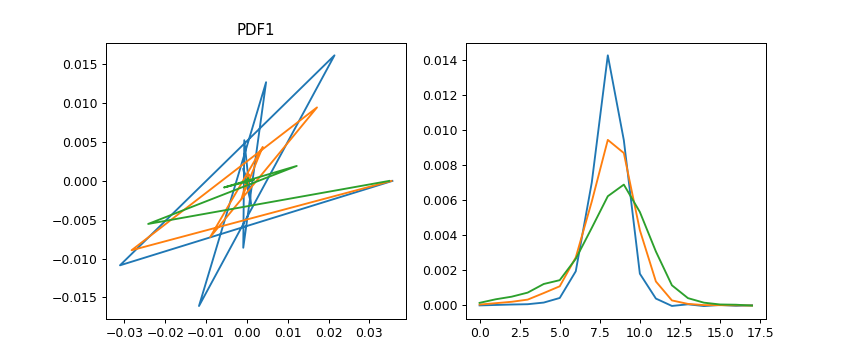

<IPython.core.display.Javascript object>


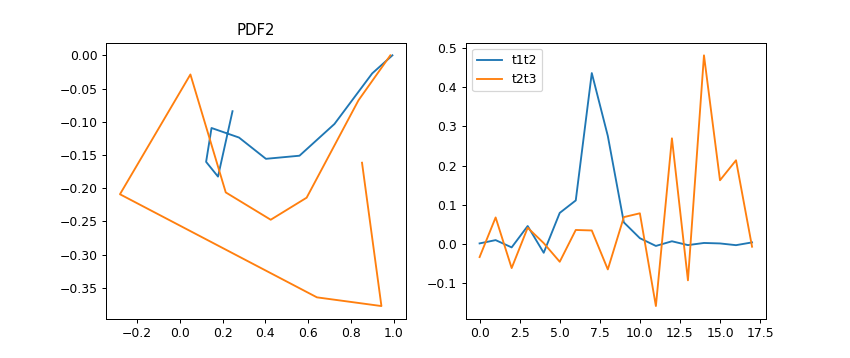

<IPython.core.display.Javascript object>


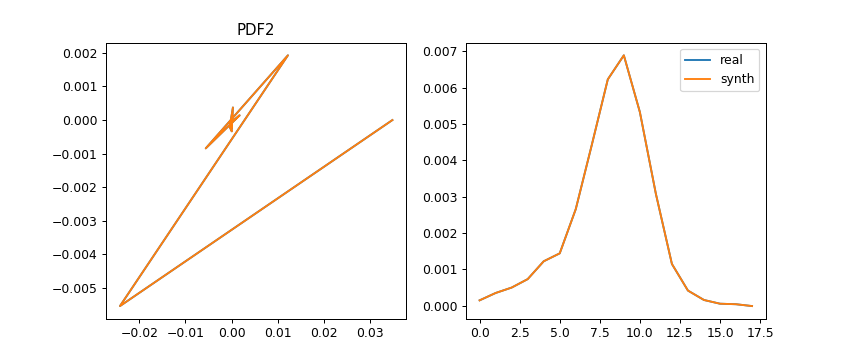

In [41]:
n_cutoff = 10
PDF_t1 = np.fft.rfft(pdf_t1,norm='ortho')
PDF_t1 = PDF_t1[0:n_cutoff]
PDF_t2 = np.fft.rfft(pdf_t2,norm='ortho')
PDF_t2 = PDF_t2[0:n_cutoff]
PDF_t3 = np.fft.rfft(pdf_t3,norm='ortho')
PDF_t3 = PDF_t3[0:n_cutoff]

PDF_t1t2 = PDF_t2 / PDF_t1
pdf_t1t2 = np.fft.irfft(PDF_t1t2)
pdf_t1t2 = np.roll(pdf_t1t2, int(fourier_shifter*len(pdf_t1t2)))

PDF_t2t3 = PDF_t3 / PDF_t2
pdf_t2t3 = np.fft.irfft(PDF_t2t3)
pdf_t2t3 = np.roll(pdf_t2t3, int(fourier_shifter*len(pdf_t2t3)))

PDF_t3_synth = PDF_t1 * PDF_t1t2 * PDF_t2t3
pdf_t3_synth = np.fft.irfft(PDF_t3_synth)
pdf_t2t3 = np.roll(pdf_t2t3, int(fourier_shifter*len(pdf_t3_synth)))

plt.figure(figsize=(9.5,4))
plt.subplot(121)
plt.title('PDF1')
plt.plot(PDF_t1.real, PDF_t1.imag, label=str(tte1))
plt.plot(PDF_t2.real, PDF_t2.imag, label=str(tte2))
plt.plot(PDF_t3.real, PDF_t3.imag, label=str(tte3))
plt.subplot(122)
plt.plot(np.fft.irfft(PDF_t1))
plt.plot(np.fft.irfft(PDF_t2))
plt.plot(np.fft.irfft(PDF_t3))

plt.figure(figsize=(9.5,4))
plt.subplot(121)
plt.title('PDF2')
plt.plot(PDF_t1t2.real, PDF_t1t2.imag, label='t1t2')
plt.plot(PDF_t2t3.real, PDF_t2t3.imag, label='t2t3')
plt.subplot(122)
plt.plot(pdf_t1t2, label='t1t2')
plt.plot(pdf_t2t3, label='t2t3')
plt.legend()

plt.figure(figsize=(9.5,4))
plt.subplot(121)
plt.title('PDF2')
plt.plot(PDF_t3.real, PDF_t3.imag, label='real')
plt.plot(PDF_t3.real, PDF_t3.imag, label='synth')
plt.subplot(122)
plt.plot(np.fft.irfft(PDF_t3), label='real')
plt.plot(np.fft.irfft(PDF_t3_synth), label='synth')
plt.legend()

### SNIPPETS

In [ ]:
# Underlying Price check
for tte, table in chains.items():
    print('TTE: {0:6.2f} => Bid: {1:.2f} Ask: {2:.2f}'.format(tte, table.iloc[[0]].Bid[0], table.iloc[[0]].Ask[0]))

In [ ]:
# Cropping TTE2
k2_out = k2 < k1[0]
k2 = k2[~k2_out]
vol2 = vol2[~k2_out]
k2_out = k2 > k1[-1]
k2 = k2[~k2_out]
vol2 = vol2[~k2_out]